In [124]:
import os
import mc
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices, build_design_matrices
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from scipy import stats
from matplotlib.ticker import PercentFormatter
from scipy.ndimage import gaussian_filter1d

In [6]:
def get_data(sub, trials):
    data_folder = "/Users/xpsy1114/Documents/projects/multiple_clocks/data/ephys_humans/derivatives"
    if not os.path.isdir(data_folder):
        print("running on ceph")
        data_folder = "/ceph/behrens/svenja/human_ABCD_ephys/derivatives"
    if trials == 'residualised':
        res_data = True
    else:
        res_data = False
    data_norm = mc.analyse.helpers_human_cells.load_norm_data(data_folder, [f"{sub:02}"], res_data = res_data)
    return data_norm, data_folder 

In [38]:
# load the latest results.
source_dir = '/Users/xpsy1114/Documents/projects/multiple_clocks/data/ephys_humans/derivatives'
group_dir_state = f"{source_dir}/group/state_lin_regs"
trials = 'all_minus_explore'
name_result = f"{group_dir_state}/state_rep_int_{trials}.csv"

results_df = pd.read_csv(name_result)
results_df.head()
print(len(results_df))

14760


In [126]:
# HELPERS
# to plot state plots
def plot_state_polar_clock(firing_across_states, title_string, ax=None, rlim=None):
    """
    Plot a polar curve like a clock:
      - 0° at 12 o'clock, clockwise (90°=3, 180°=6, 270°=9).
      - Colors the four equal angular quarters.
      - Places A,B,C,D at 3,6,9,12 o'clock respectively.
    """
    # Colors for quadrants A, B, C, D
    colors = ['#F15A29', '#F7931E', '#C7C6E2', '#6B60AA']
    letters = ['A', 'B', 'C', 'D']  # map to 3,6,9,12 o'clock

    vals = np.asarray(firing_across_states, dtype=float)
    n_bins = len(vals)
    if n_bins < 4:
        raise ValueError("Need at least 4 bins to define quadrants.")

    # Create or reuse axis
    created_fig = False
    if ax is None:
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(1, 1, 1, projection='polar')
        created_fig = True

    # --- Clock orientation ---
    ax.set_theta_zero_location('N')   # 0° at 12 o'clock
    ax.set_theta_direction(-1)        # clockwise

    # One angle per sample
    theta = np.linspace(0, 2*np.pi, n_bins, endpoint=False)

    # --- Plot each colored quadrant (use exact bin splits; no assumption about 360 bins) ---
    # 4 equal segments across n_bins
    edges = np.linspace(0, n_bins, 5, dtype=int)
    for i in range(4):
        s, e = edges[i], edges[i+1]
        if e > s:
            ax.plot(theta[s:e], vals[s:e], color=colors[i], linewidth=3)

    # --- r-limits ---
    if rlim is None:
        rmin = float(np.nanmin(vals))
        rmax = float(np.nanmax(vals))
    else:
        rmin, rmax = rlim
    ax.set_ylim(rmin, rmax)

    # --- Shaded wedges up to quadrant mean ---
    quad_means = []
    for i in range(4):
        s, e = edges[i], edges[i+1]
        quad_means.append(np.nanmean(vals[s:e]) if e > s else np.nan)
    quad_means = np.asarray(quad_means)

    # Center angle and width per quadrant (exact, even if bins not divisible by 4)
    for i in range(4):
        s, e = edges[i], edges[i+1]
        if e <= s: 
            continue
        center_idx = (s + e) / 2.0
        center_ang = (center_idx / n_bins) * 2*np.pi
        width = ((e - s) / n_bins) * 2*np.pi
        m = quad_means[i]
        if np.isfinite(m):
            ax.bar(center_ang,
                   max(0, m - rmin),
                   width=width,
                   bottom=rmin,
                   color=colors[i],
                   alpha=0.25,
                   edgecolor='none',
                   zorder=0,
                   align='center')

    # --- Labels at 3,6,9,12 o'clock: A,B,C,D ---
    # Angles in radians: 3→90°, 6→180°, 9→270°, 12→0°
    # label_angles = np.deg2rad([90, 180, 270, 0])
    # label_r = rmax*1.3
    # for lab, ang, col in zip(letters, label_angles, colors):
    #     ax.text(ang, label_r, lab, ha='center', va='bottom',
    #             fontsize=22, fontweight='bold', color=col)

    label_angles = np.deg2rad([0, 90, 180, 270])   # A(3), B(6), C(9), D(12)
    letters      = ['A', 'B', 'C', 'D']
    colors       = ['#F15A29', '#F7931E', '#C7C6E2', '#6B60AA']

    # Put labels a constant radial padding outside the data circle
    pad = 0.12 * (rmax - rmin) if np.isfinite(rmin) and np.isfinite(rmax) else 0.1
    label_r = rmax + pad
    
    for lab, ang, col in zip(letters, label_angles, colors):
        # Choose alignment by quadrant so text sits outside the circle:
        if np.isclose(ang, 0):            # 12 o'clock (D)
            ha, va = 'center', 'bottom'
        elif np.isclose(ang, np.pi/2):    # 3 o'clock (A)
            ha, va = 'left',   'center'
        elif np.isclose(ang, np.pi):      # 6 o'clock (B)
            ha, va = 'center', 'top'
        elif np.isclose(ang, 3*np.pi/2):  # 9 o'clock (C)
            ha, va = 'right',  'center'
        else:
            ha, va = 'center', 'center'
    
        ax.text(ang, label_r, lab,
                ha=ha, va=va, fontsize=28, fontweight='bold', color=col,
                clip_on=False)  # don't clip at axes boundary
        
    # Hide numeric theta ticks (keep grid if you like)
    ax.set_xticks([])

    # ax.set_title(title_string, va='bottom', fontsize=22)
    ax.grid(True)

    if created_fig:
        #plt.tight_layout()
        plt.show()

        
        
def smooth_circular(arr, sigma=2):
    """
    Apply Gaussian smoothing to circular data (like 360-bin polar plots).
    Wraps data before smoothing to avoid edge artifacts.
    """
    extended = np.concatenate([arr, arr, arr])  # tripled to allow wrap-around
    smoothed = gaussian_filter1d(extended, sigma=sigma)
    return smoothed[len(arr):2*len(arr)]  # return center part


In [46]:
# exclude session 39 because something went wrong here
results_df = results_df[results_df['session'] != 39]
print(len(results_df))
results_df.head()

14565


,Unnamed: 0,session,neuron,roi,model,term,beta,t,p,F,p_F
0,0,1,01_01-01-chan99-OFC,OFC,M1_main,A,-0.042089,-1.986949,0.046928,2.334877,0.053168
1,1,1,01_01-01-chan99-OFC,OFC,M1_main,B,-0.037729,-1.766428,0.077324,2.334877,0.053168
2,2,1,01_01-01-chan99-OFC,OFC,M1_main,C,-0.032211,-1.560763,0.118580,2.334877,0.053168
3,3,1,01_01-01-chan99-OFC,OFC,M1_main,D,-0.058933,-2.820865,0.004789,2.334877,0.053168
4,4,1,01_01-01-chan99-OFC,OFC,M1_main,rep_c,-0.000552,-0.327001,0.743667,2.334877,0.053168


OFC
entorhinal
ACC
hippocampal
PCC
mixed


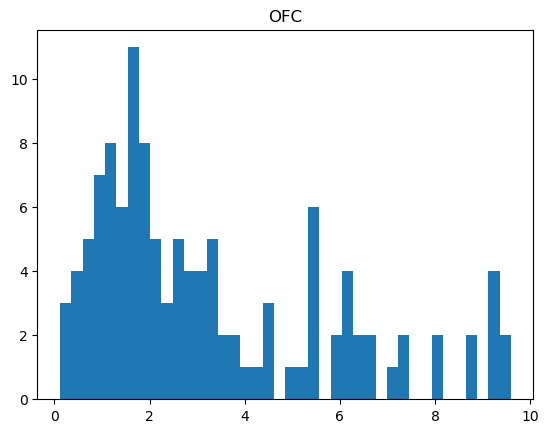

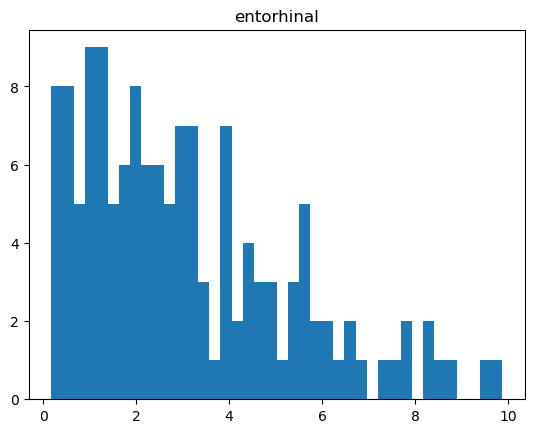

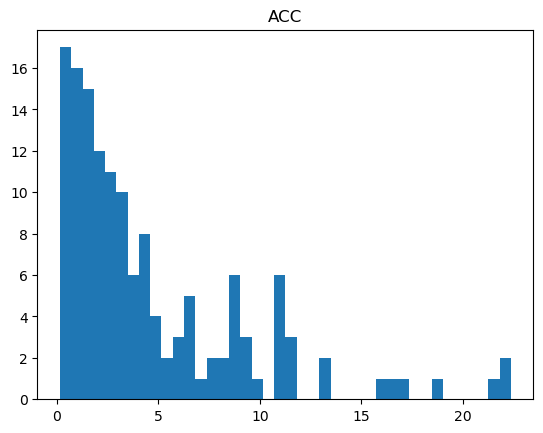

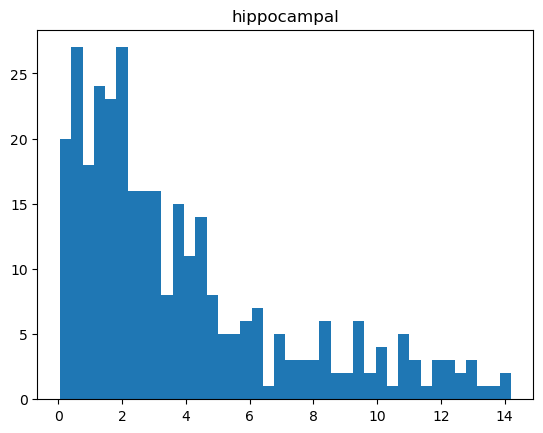

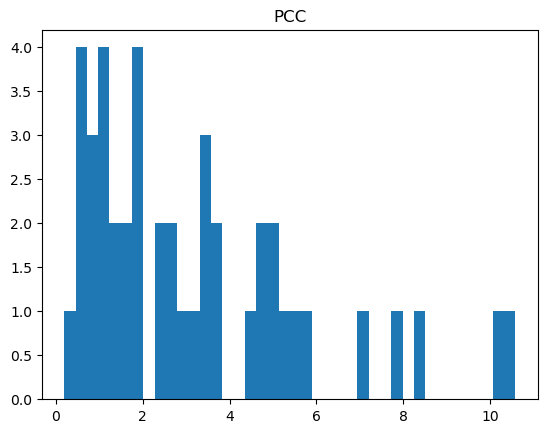

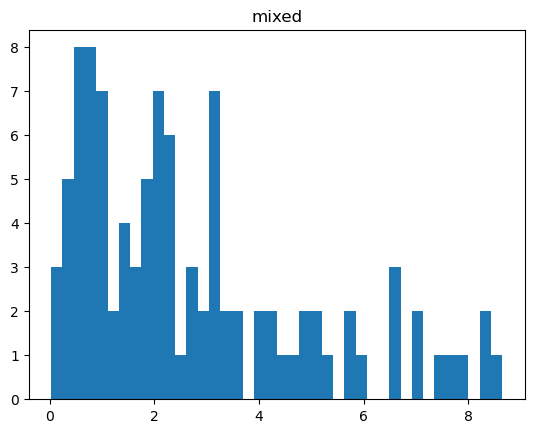

In [50]:
rois = results_df['roi'].unique()

for roi in rois:
    print(roi)
    main_effect_state_roi = results_df[(results_df['roi'] == roi) & (results_df['term'] == 'A') & (results_df['model'] == 'M1_main')].copy()
    x = main_effect_state_roi['F'].copy()
    thresh = np.quantile(np.abs(x), .90)
    plt.figure()
    _ = plt.hist(x[np.abs(x)<thresh], bins = 40)
    plt.title(roi)

OFC
entorhinal
ACC
hippocampal
PCC
mixed


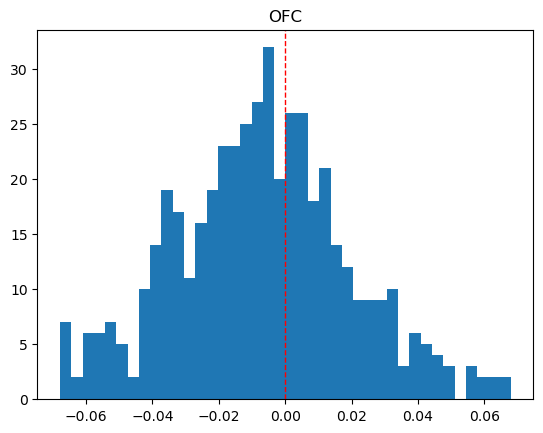

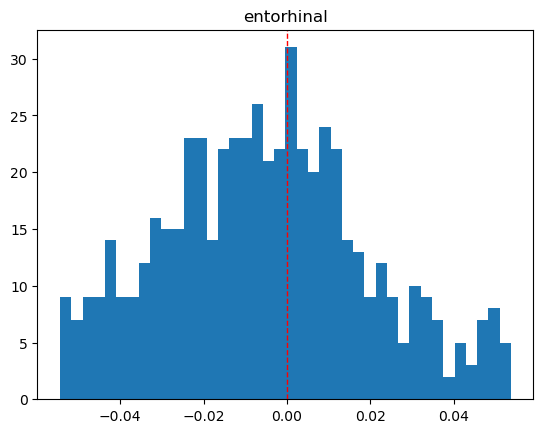

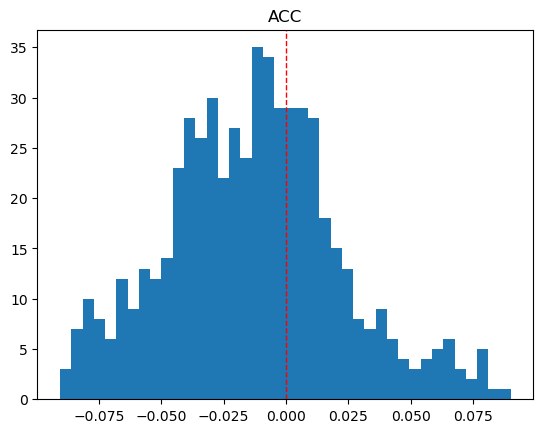

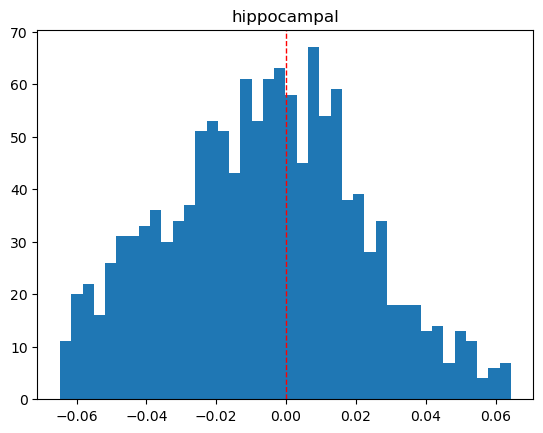

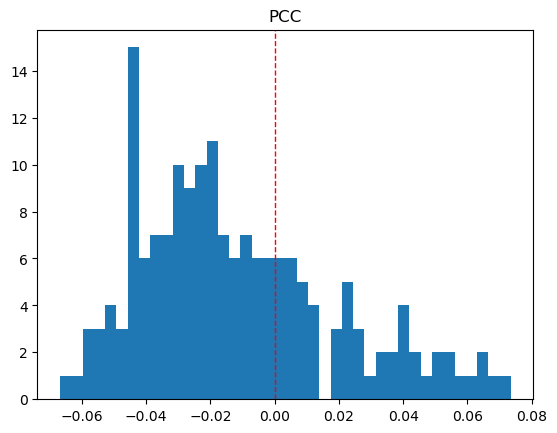

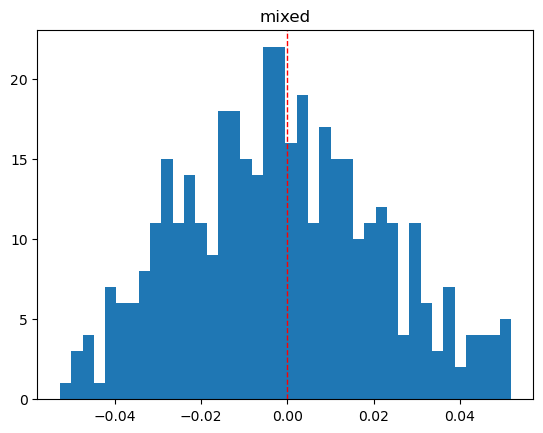

In [55]:
for roi in rois:
    print(roi)
    effect_state_roi = results_df[(results_df['roi'] == roi) & (results_df['term'] != 'rep_c') & (results_df['term'] != 'correct') & (results_df['model'] == 'M1_main')].copy()
    x = effect_state_roi['beta'].copy()
    thresh = np.quantile(np.abs(x), .90)
    plt.figure()
    _ = plt.hist(x[np.abs(x)<thresh], bins = 40)
    plt.axvline(0, ls="--", lw=1, c='red')
    plt.title(roi)

F threshold: 20.131120183574748


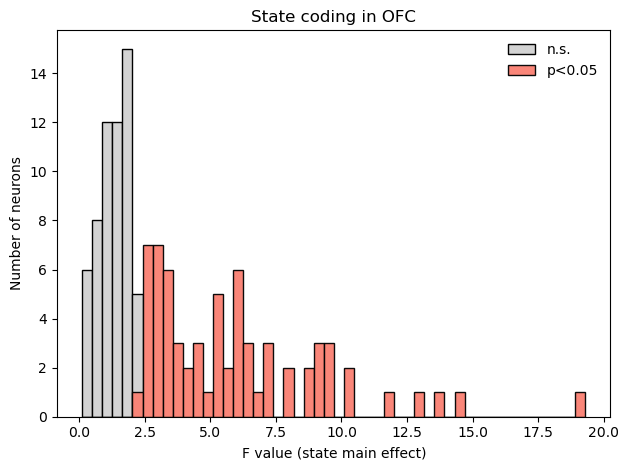

F threshold: 13.614440969296352


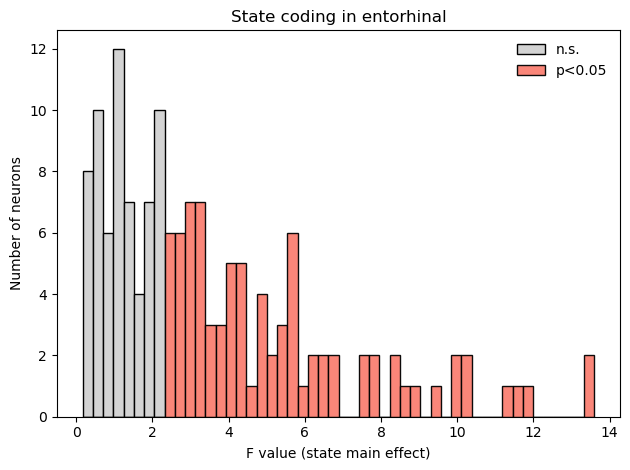

F threshold: 41.44777833702469


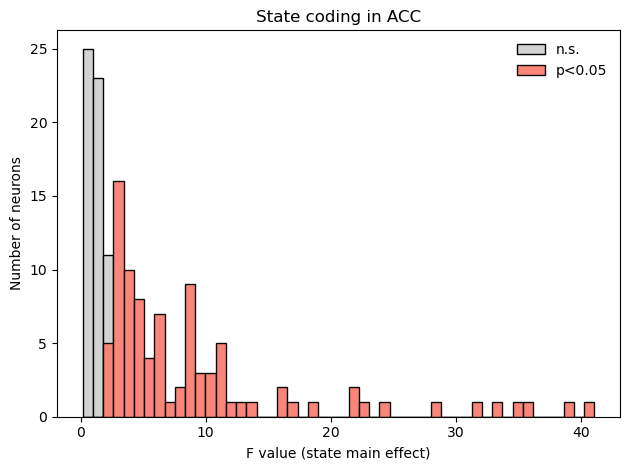

F threshold: 23.796321312780506


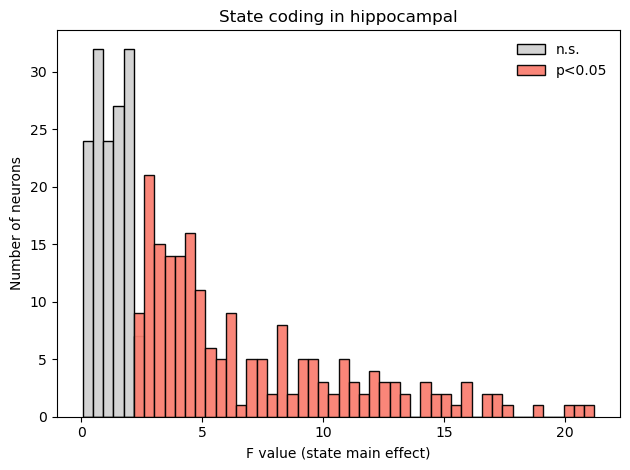

F threshold: 13.162363354298146


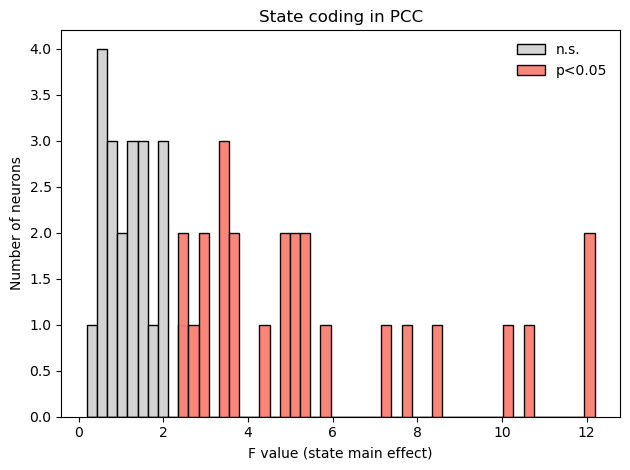

F threshold: 13.67122247017606


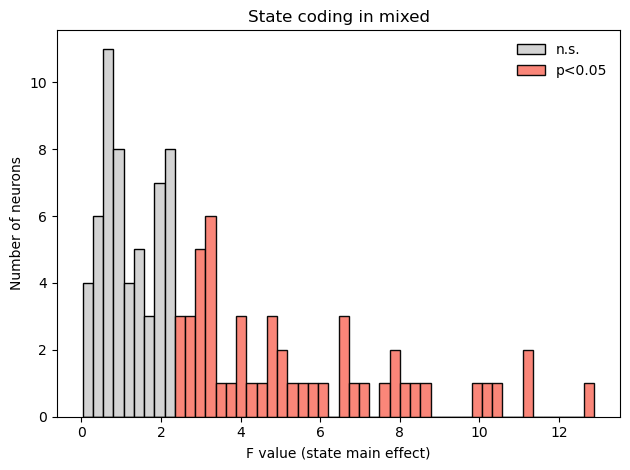

In [109]:
# 1) Keep only main-effect model rows, and one row per neuron
state_df = (
    results_df
    .query("model == 'M1_main'")
    [["session", "neuron", "roi", "F", "p_F"]]
    .drop_duplicates()
)
state_df.head()

for roi in rois:
    state_df_roi = state_df[state_df['roi'] == roi].copy()
    all_vals = state_df_roi["F"]
    thresh = np.quantile(np.abs(all_vals), .95)
    print("F threshold:", thresh)
    # also make sure none of the values is rediculously high.
    valid_mask = np.abs(state_df_roi["F"]) < thresh

    # 2) Split sig / non-sig, but only keep valid F values
    sig_mask    = (state_df_roi["p_F"] < 0.05) & valid_mask
    nonsig_mask = (state_df_roi["p_F"] >= 0.05) & valid_mask

    F_sig    = state_df_roi.loc[sig_mask, "F"]
    F_nonsig = state_df_roi.loc[nonsig_mask, "F"]

    # 3) Compute bin edges based only on valid values
    valid_F = state_df_roi.loc[valid_mask, "F"]
    bin_edges = np.histogram_bin_edges(valid_F, bins=50)

    plt.figure()
    _ = plt.hist(F_nonsig, bins = bin_edges, color='lightgray', edgecolor='black', alpha=1.0, label='n.s.')
    _ = plt.hist(F_sig, bins=bin_edges, color='salmon', edgecolor='black', alpha=0.95, label=f'p<0.05')


    plt.xlabel("F value (state main effect)")
    plt.ylabel("Number of neurons")
    plt.title(f"State coding in {roi}")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

t-val threshold: 7.75640312925963


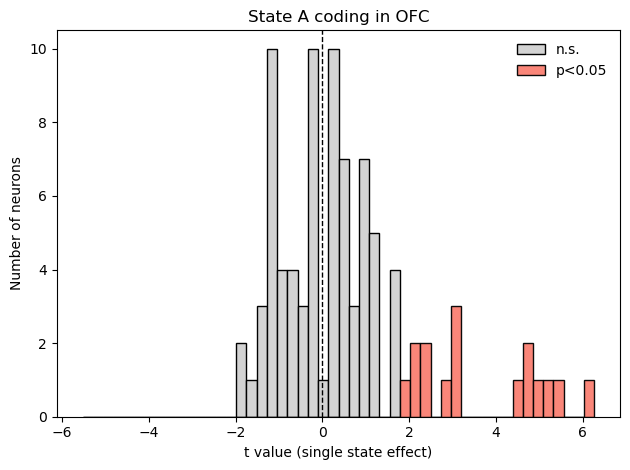

t-val threshold: 6.710707428788819


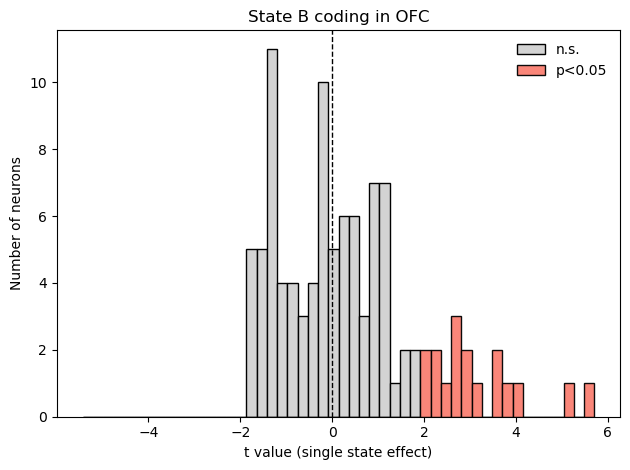

t-val threshold: 7.259868791060265


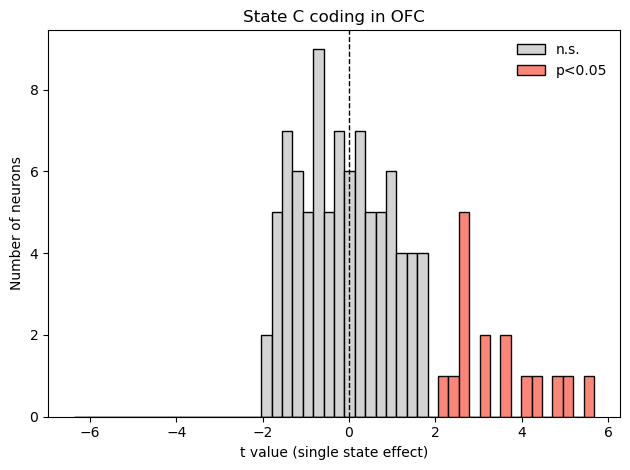

t-val threshold: 7.058586529282005


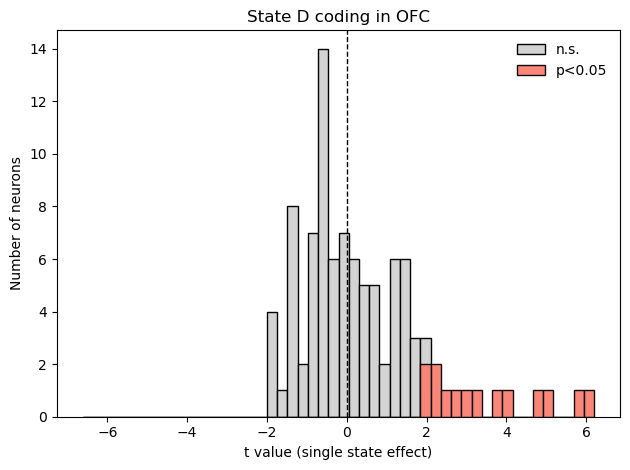

t-val threshold: 7.21957826186697


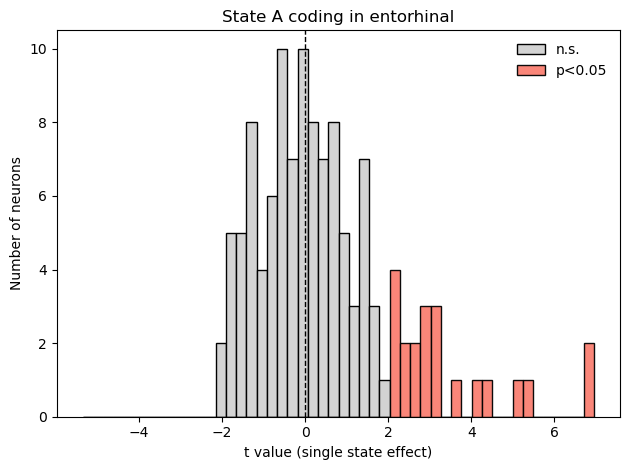

t-val threshold: 6.7056723558478515


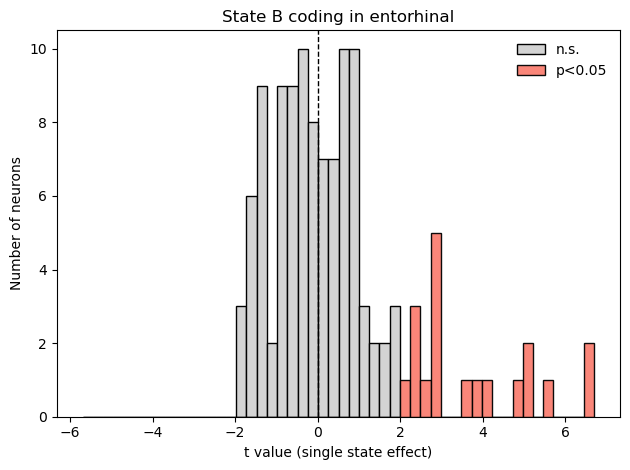

t-val threshold: 7.132056705365669


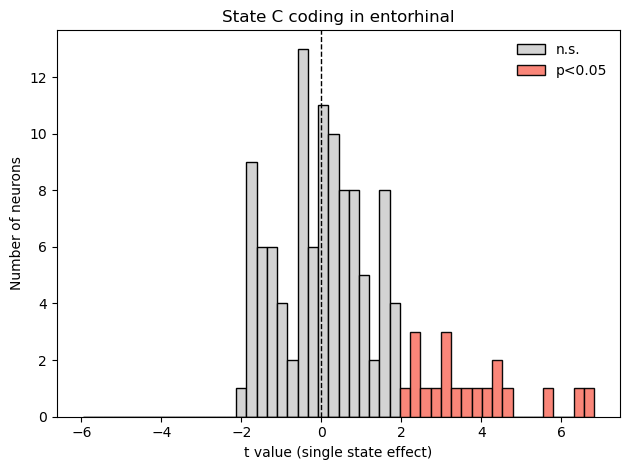

t-val threshold: 6.370492302989631


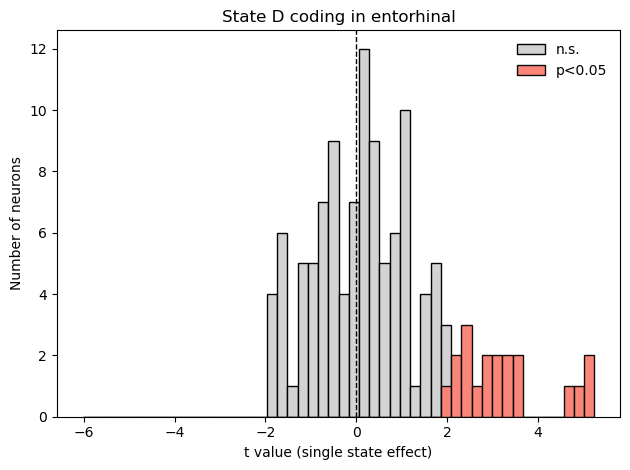

t-val threshold: 20.848943933964087


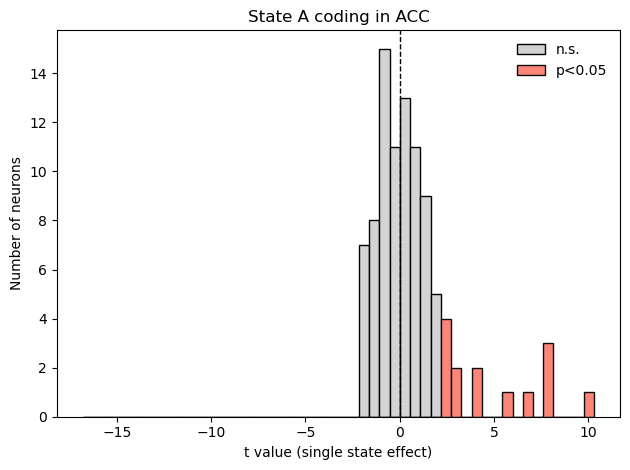

t-val threshold: 20.589341062357676


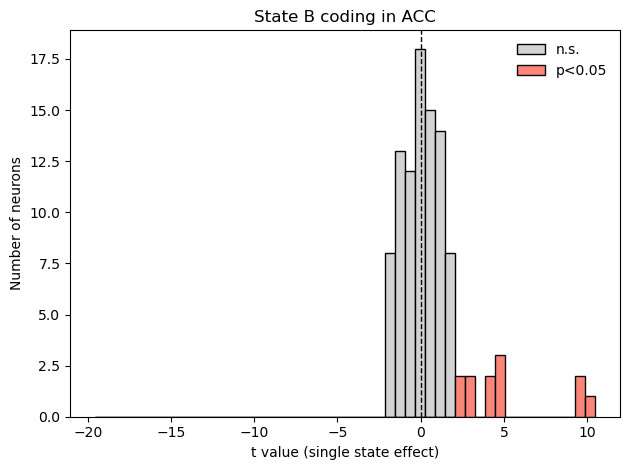

t-val threshold: 15.1933953537166


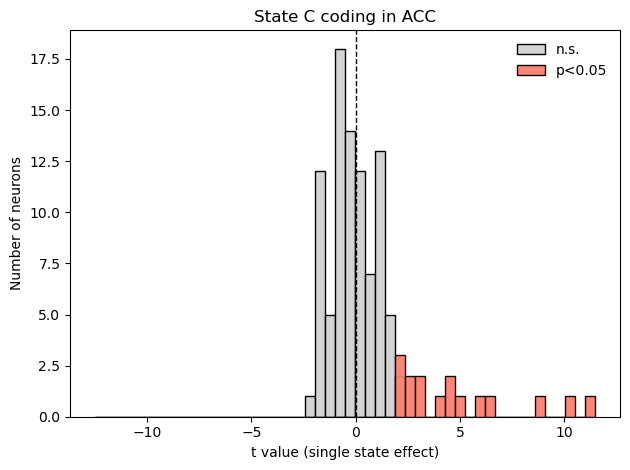

t-val threshold: 17.697602892913586


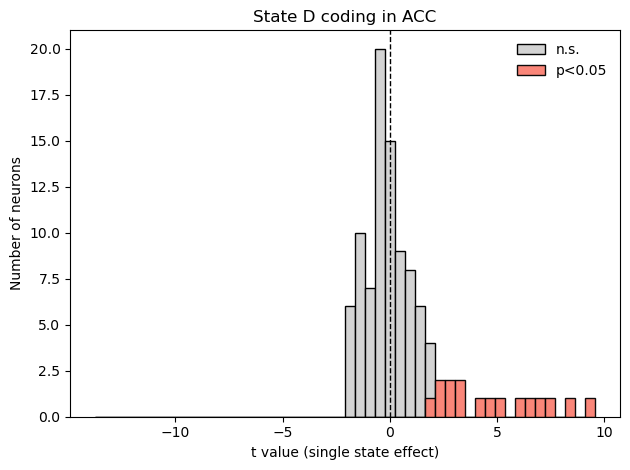

t-val threshold: 10.704337958218678


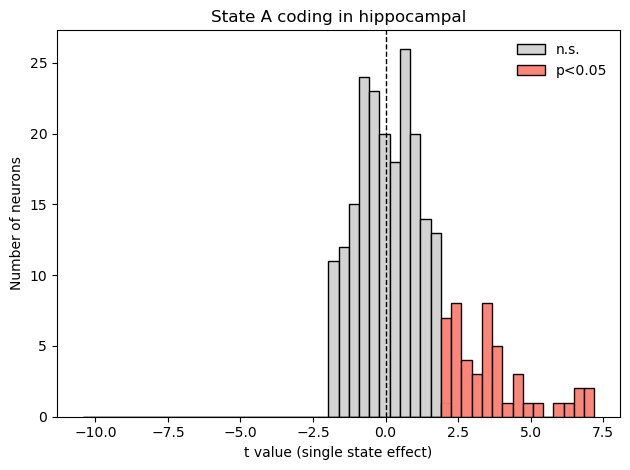

t-val threshold: 10.295945810368687


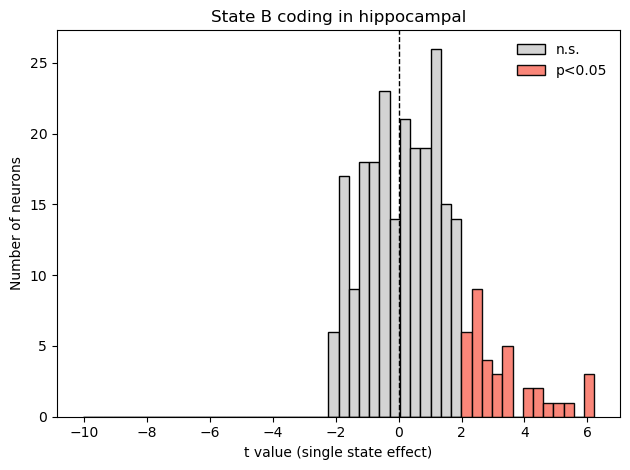

t-val threshold: 8.871700327127867


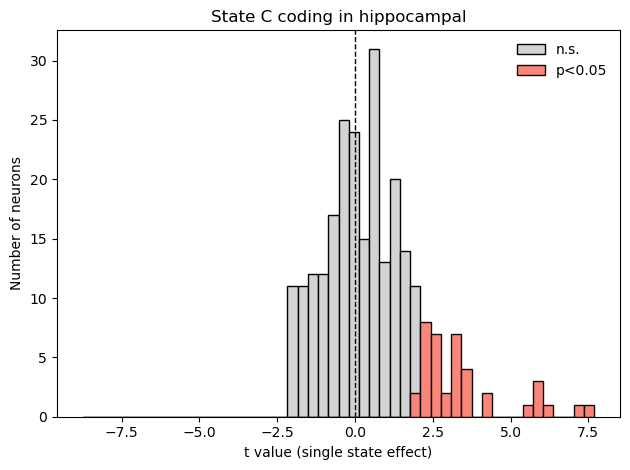

t-val threshold: 9.606864956769103


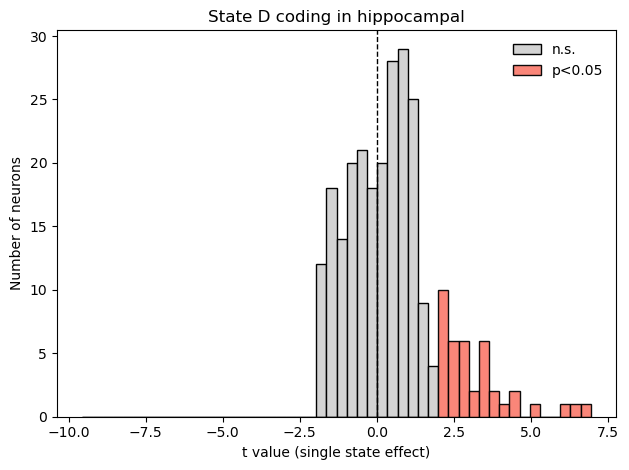

t-val threshold: 6.222765430965766


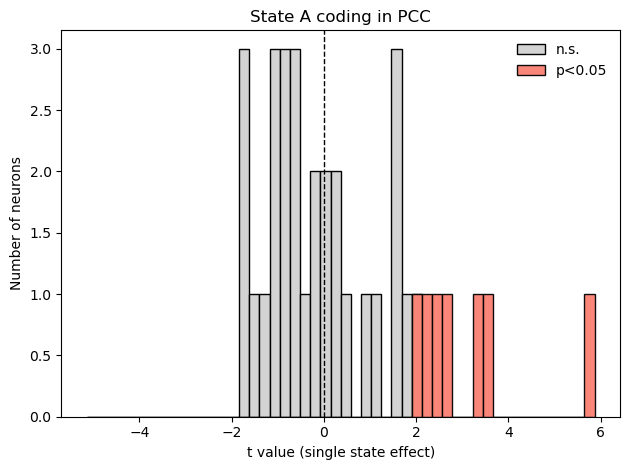

t-val threshold: 7.18283627720453


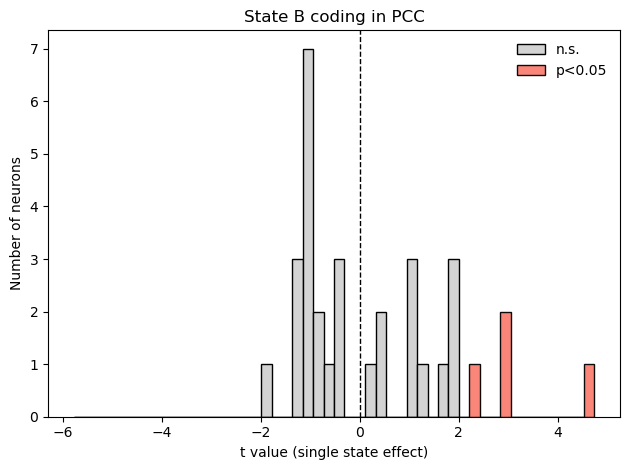

t-val threshold: 5.798655285454612


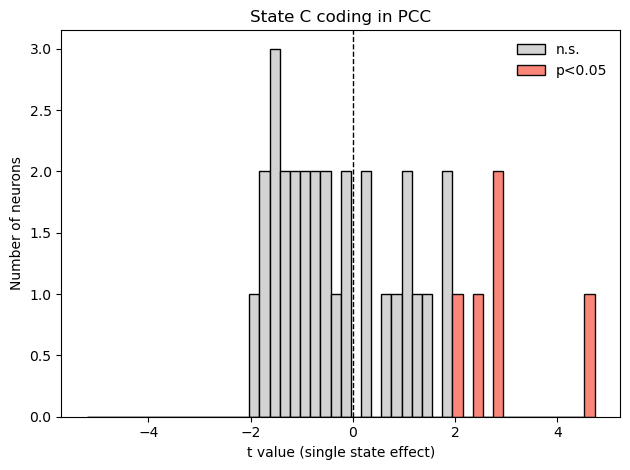

t-val threshold: 6.788415118785749


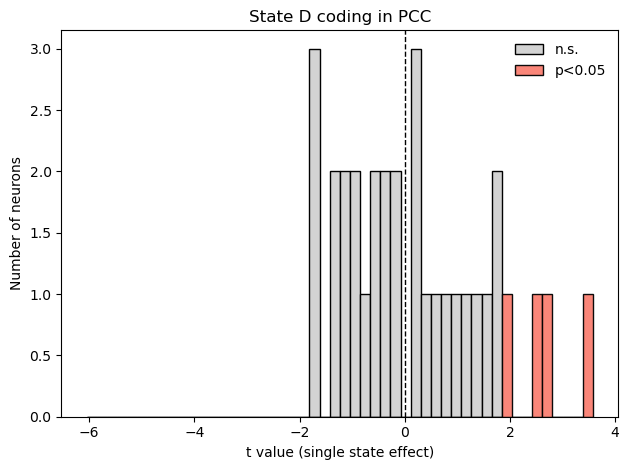

t-val threshold: 6.317875097509021


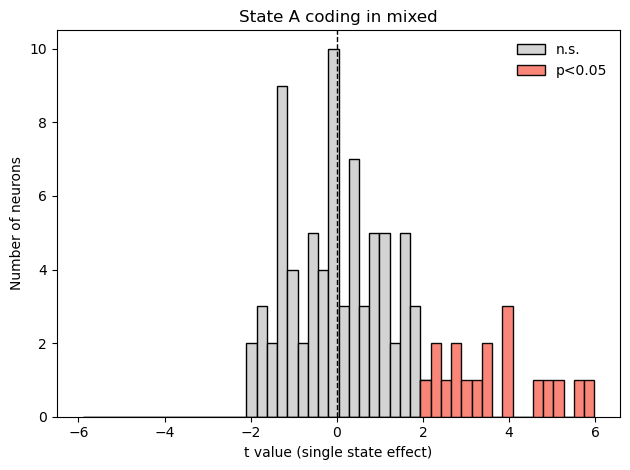

t-val threshold: 5.58447911041398


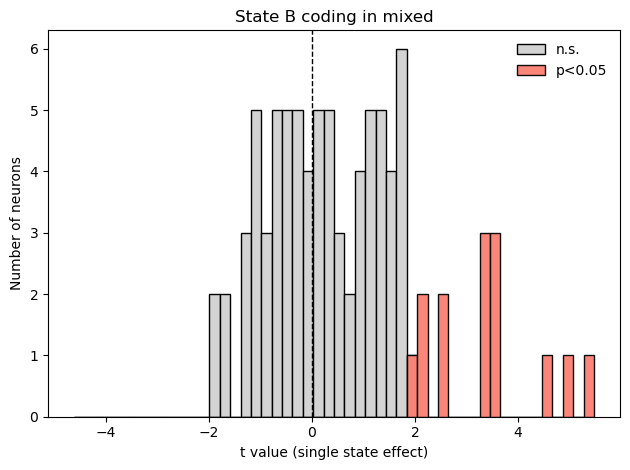

t-val threshold: 5.457143908514427


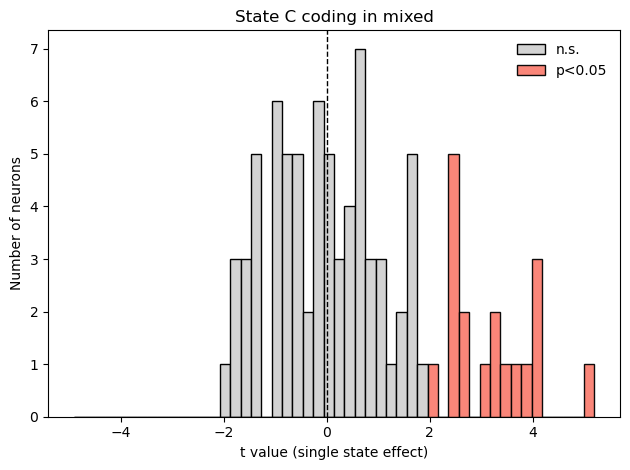

t-val threshold: 5.937079922431163


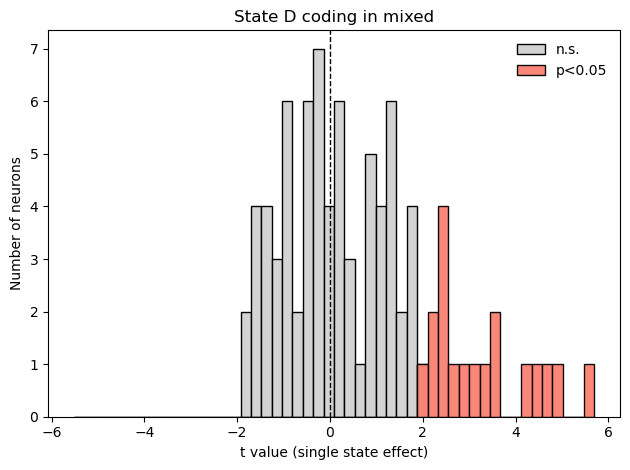

In [110]:
# 1) Keep only main-effect model rows, and one row per neuron
main_df = (
    results_df
    .query("model == 'M1_main'")
    [["session", "neuron", "roi", "term","t", "p"]]
    .drop_duplicates()
)
main_df.head()

for roi in rois:
    df_roi = main_df[main_df['roi'] == roi].copy()
    for state in ['A', 'B', 'C', 'D']:
        state_roi_df = df_roi[df_roi['term'] == state].copy()
state_roi_df.head()


for roi in rois:
    df_roi = main_df[main_df['roi'] == roi].copy()
    for state in ['A', 'B', 'C', 'D']:
        state_roi_df = df_roi[df_roi['term'] == state].copy()
        
        all_vals = state_roi_df['t']
        
        thresh = np.quantile(np.abs(all_vals), .99)
        print("t-val threshold:", thresh)

        # also make sure none of the values is rediculously high.
        valid_mask = np.abs(state_roi_df['t']) < thresh

        # 2) Split sig / non-sig, but only keep valid F values
        sig_mask    = (state_roi_df["p"] < 0.05) & valid_mask & (state_roi_df['t'] > 0)
        nonsig_mask = (state_roi_df["p"] >= 0.05) & valid_mask

        t_sig    = state_roi_df.loc[sig_mask, "t"]
        t_nonsig = state_roi_df.loc[nonsig_mask, "t"]

        # 3) Compute bin edges based only on valid values
        valid_t = state_roi_df.loc[valid_mask, "t"]
        bin_edges = np.histogram_bin_edges(valid_t, bins=50)

        plt.figure()
        _ = plt.hist(t_nonsig, bins = bin_edges, color='lightgray', edgecolor='black', alpha=1.0, label='n.s.')
        _ = plt.hist(t_sig, bins=bin_edges, color='salmon', edgecolor='black', alpha=0.95, label=f'p<0.05')
        plt.axvline(0, ls="--", lw=1, c='black')

        plt.xlabel("t value (single state effect)")
        plt.ylabel("Number of neurons")
        plt.title(f"State {state} coding in {roi}")
        plt.legend(frameon=False)
        plt.tight_layout()
        plt.show()

In [130]:
# next, plot single well-performing neurons.
# start from your existing state_df
state_df.head()

# make sure we have one row per neuron (M1_main, per neuron/roi/session)
state_unique = (
    state_df[["session", "neuron", "roi", "F", "p_F"]]
    .drop_duplicates()
    .copy()
)

# 1) Compute threshold for "reasonable" F-values (e.g. 95th percentile)
all_vals = state_unique["F"].astype(float)
thresh = np.quantile(np.abs(all_vals), 0.95)
print("F-value threshold (90th percentile of |F|):", thresh)

# 2) Keep only neurons with reasonable F
reasonable = state_unique[np.abs(state_unique["F"]) < thresh].copy()

# 3) Sort by F descending and take top 10
top10 = reasonable.sort_values("F", ascending=False).head(10)

# 4) Print them nicely
print("\nTop 10 neurons (reasonable F-values only):")
print(top10[["session", "neuron", "roi", "F", "p_F"]].to_string(index=False))

target_cells = top10['neuron'].to_list()

    

F-value threshold (90th percentile of |F|): 21.17637141868493

Top 10 neurons (reasonable F-values only):
 session                  neuron         roi         F          p_F
      61 61_14-14-mLF3aOFC05-OFC         OFC 21.152565 1.871218e-17
      25   25_35-35-mRT2bHb07-HC hippocampal 20.638909 5.097679e-17
      50    50_06-06-elec39-LINS       mixed 20.364048 8.712021e-17
      43   43_18-18-mRT2cHb03-HC hippocampal 20.020129 1.704174e-16
      48     48_08-08-mROFC4-OFC         OFC 19.295392 6.985398e-16
      60  60_16-16-GA3-RO5-OCCIP       mixed 19.179948 8.749157e-16
      12   12_17-17-mRT2bHb08-HC hippocampal 18.958890 1.345830e-15
      50     50_13-13-elec62-PCC         PCC 18.879186 1.572848e-15
      41   41_20-20-mRAMCC8-RAMC         ACC 18.839657 1.698975e-15
      10   10_13-13-mRT2bHb06-HC hippocampal 17.619970 1.821394e-14


       session                   neuron  roi          F           p_F
13440       61  61_14-14-mLF3aOFC05-OFC  OFC  21.152565  1.871218e-17
{'A_p': array([0.39950308]), 'A_t': array([0.84250904]), 'B_p': array([0.17227558]), 'B_t': array([-1.36492833]), 'C_p': array([0.75794472]), 'C_t': array([-0.30818085]), 'D_p': array([0.24602739]), 'D_t': array([1.16005261])}
loading files for subject 61
[13]
target cell is 61_14-14-mLF3aOFC05-OFC


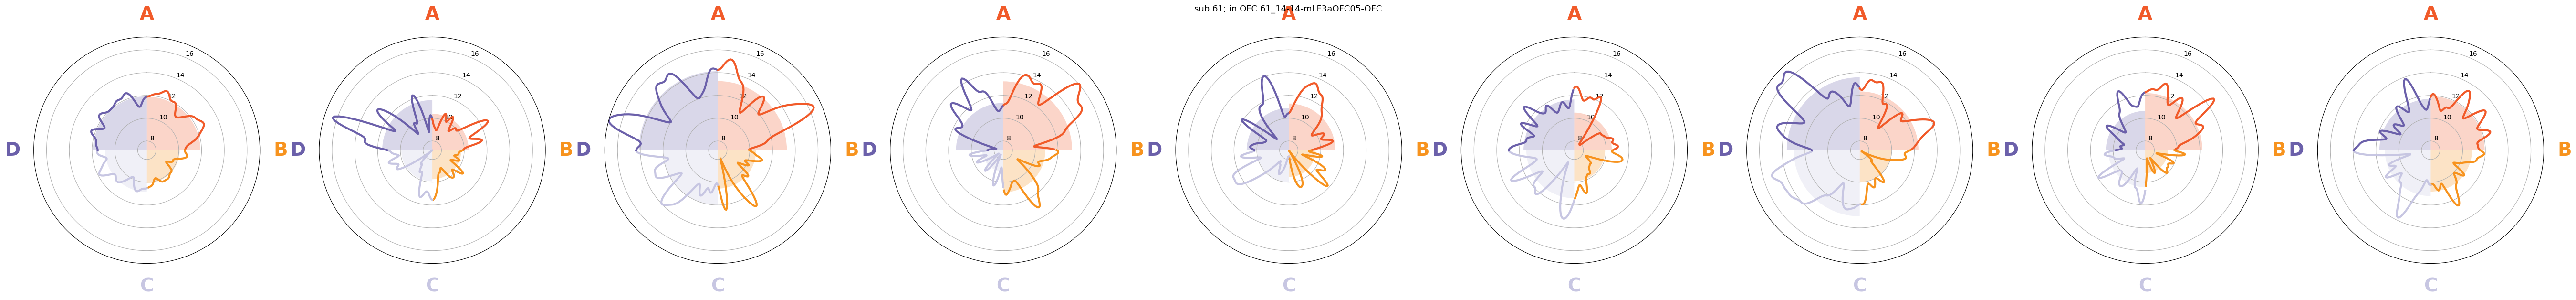

In [144]:
chosen_top_neuron = 0

session = int(target_cells[chosen_top_neuron][0:2])
sesh = f"{session:02}"
#target_cells = top_sig_state_cells[top_sig_state_cells['session_id']==s]['neuron_id'].to_list()
#avg_corr_target_cells = top_sig_state_cells[top_sig_state_cells['session_id']==s]['state_cv_consistency'].to_list()
#rois = top_sig_state_cells[top_sig_state_cells['session_id']==s]['roi'].to_list()
#print(target_cells)

print(top10[top10['neuron'] == target_cells[idx]])


curr_neuron_results = results_df[(results_df['neuron'] == target_cells[idx]) & (results_df['model'] == 'M1_main')]
state_dict = {}
for state in ['A', 'B', 'C', 'D']:
    state_dict[f"{state}_p"] = curr_neuron_results[curr_neuron_results['term'] == state]['p'].to_numpy()
    state_dict[f"{state}_t"] = curr_neuron_results[curr_neuron_results['term'] == state]['t'].to_numpy()
print(state_dict)

data_folder = "/Users/xpsy1114/Documents/projects/multiple_clocks/data/ephys_humans/derivatives"
subjects = [sesh]
data_norm = mc.analyse.helpers_human_cells.load_norm_data(data_folder, subjects)


# the same script but for data norm
target_idx = [
    idx for idx, label_cell in enumerate(data_norm[f"sub-{sesh}"]['electrode_labels'])
    if any(target in label_cell or label_cell in target for target in target_cells)
]

print(target_idx)

# import pdb; pdb.set_trace()
# find out which grids are unique
grid_cols = ['loc_A', 'loc_B', 'loc_C', 'loc_D']
unique_grids, idx_unique_grid, idx_same_grids, counts = np.unique(
    data_norm[f"sub-{sesh}"]['beh'][grid_cols].to_numpy(),
    axis=0,
    return_index=True,
    return_inverse=True,
    return_counts=True
)

# AVERAGE OVER THE SAME GRIDS!!
# for i, unique_task_idx in enumerate(idx_unique_grid): 
#import pdb; pdb.set_trace()
for t_idx, target_cell in enumerate(target_cells):
    for curr_neuron in data_norm[f"sub-{sesh}"]['normalised_neurons']:
        if target_cell in curr_neuron:
            print(f"target cell is {target_cell}")
            #import pdb; pdb.set_trace()
            smoothed_firing_across_tasks = smooth_circular(np.mean(data_norm[f"sub-{sesh}"]['normalised_neurons'][curr_neuron].to_numpy(), axis = 0), sigma=4) 
            panels = [smoothed_firing_across_tasks]
            titles = ["TASK AVG"]

            for task_id, grid_config in enumerate(unique_grids):
                mask_curr_task = (idx_same_grids == task_id)
                neurons_curr_task = data_norm[f"sub-{sesh}"]['normalised_neurons'][curr_neuron].to_numpy()[mask_curr_task]
                avg_firing_curr_grid = list(np.mean(neurons_curr_task, axis = 0))
                smoothed_firing_curr_task = smooth_circular(avg_firing_curr_grid, sigma=4)  # tweak sigma as needed
                panels.append(smoothed_firing_curr_task)
                titles.append(f"task {grid_config}")

            # 3) make ONE figure with N polar subplots and shared r-limits (tiny addition)
            n_panels = len(panels)
            fig, axes = plt.subplots(1, n_panels, subplot_kw=dict(projection='polar'),
                                     figsize=(6*n_panels, 6))
            if n_panels == 1:
                axes = np.array([axes])

            # shared radial limits for fair comparison (NEW but minimal)
            rmin = float(np.nanmin([np.nanmin(p) for p in panels]))
            rmax = float(np.nanmax([np.nanmax(p) for p in panels]))
            rlim = (rmin, rmax)

            # 4) draw each panel using your SAME plotting function
            # for ax, series, title in zip(axes, panels, titles):
            #     plot_state_polar(series, title, ax=ax, rlim=rlim)
            for ax, series, title in zip(axes, panels, titles):
                plot_state_polar_clock(series, title, ax=ax, rlim=rlim)


            fig.suptitle(f"sub {sesh}; in {rois[t_idx]} {target_cell}", y=0.98, fontsize=13)
            plt.tight_layout()
            plt.show()